In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional ,Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:

data = open('lspd.txt', encoding='utf=8').read()

corpus = data.split("\n")
len(corpus)

4092

In [3]:
import re
cleaned_corpus = []
tokenizer = Tokenizer()

for line in corpus:
    res = re.sub('[!,*)@।#%(&$_?.^]', '', line)
    cleaned_corpus.append(res)

tokenizer.fit_on_texts(cleaned_corpus)
total_words = len(tokenizer.word_index) + 1

In [4]:
cleaned_corpus[:10]

['नछाडी जानोस् हे मेरा प्राण  अकेली मलाई',
 'मनको वनमा ननिभ्ने गरी विरह जलाई ',
 'ननिभ्ने गरी विरह जलाई',
 'लोचनका तारा  हे मेर प्यारा  यो जोति  बिलाए ',
 'के भनूँ भन्ने म केही थिइन  विष नै पिलाए ',
 'प्यारा  विष नै पिलाए ',
 'मनको कुरा गलामा अड्छ अड्कन्छ गलामा',
 'यो मेरो मुटु पचासबाजी धड्कन्छ पलामा ',
 'यो छाती मेरो चिरेर खोली नजर गराए',
 'त्यो मन केही फर्कंदो होला तस्विर खुलाए']

In [5]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(cleaned_corpus)

In [6]:
print(len(inp_sequences))
inp_sequences[:5]

14827


[[1337, 2623],
 [1337, 2623, 12],
 [1337, 2623, 12, 39],
 [1337, 2623, 12, 39, 103],
 [1337, 2623, 12, 39, 103, 628]]

In [7]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [8]:
max_sequence_len

11

In [17]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1

    model = Sequential()

    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))

    model.add(Bidirectional(LSTM(150, return_sequences = True)))

    model.add(Dropout(0.2))
    model.add(LSTM(100))

    model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(total_words, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           861300    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 4306)              434906    
_________________________________________________________________
dense_3 (Dense)              (None, 8613)              37096191  
Total params: 38,853,997
Trainable params: 38,853,997
Non-trainable params: 0
__________________________________________

In [18]:
history  = model.fit(predictors, label, epochs=100, verbose=1 )

Epoch 1/100
464/464 [==============================] - 147s 306ms/step - loss: 8.7116 - accuracy: 0.0127
Epoch 2/100
464/464 [==============================] - 141s 303ms/step - loss: 8.2295 - accuracy: 0.0134
Epoch 3/100
464/464 [==============================] - 141s 303ms/step - loss: 8.0459 - accuracy: 0.0139
Epoch 4/100
464/464 [==============================] - 29s 61ms/step - loss: 7.9278 - accuracy: 0.0140
Epoch 5/100
464/464 [==============================] - 32s 69ms/step - loss: 7.8145 - accuracy: 0.0142
Epoch 6/100
464/464 [==============================] - 26s 56ms/step - loss: 7.7058 - accuracy: 0.0142
Epoch 7/100
464/464 [==============================] - 22s 48ms/step - loss: 7.6200 - accuracy: 0.0142
Epoch 8/100
464/464 [==============================] - 22s 48ms/step - loss: 7.5267 - accuracy: 0.0136
Epoch 9/100
464/464 [==============================] - 22s 48ms/step - loss: 7.4306 - accuracy: 0.0138
Epoch 10/100
464/464 [==============================] - 22s 48ms/st

In [25]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.jpg",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

In [20]:
model.save('BILSTM_100.h5')

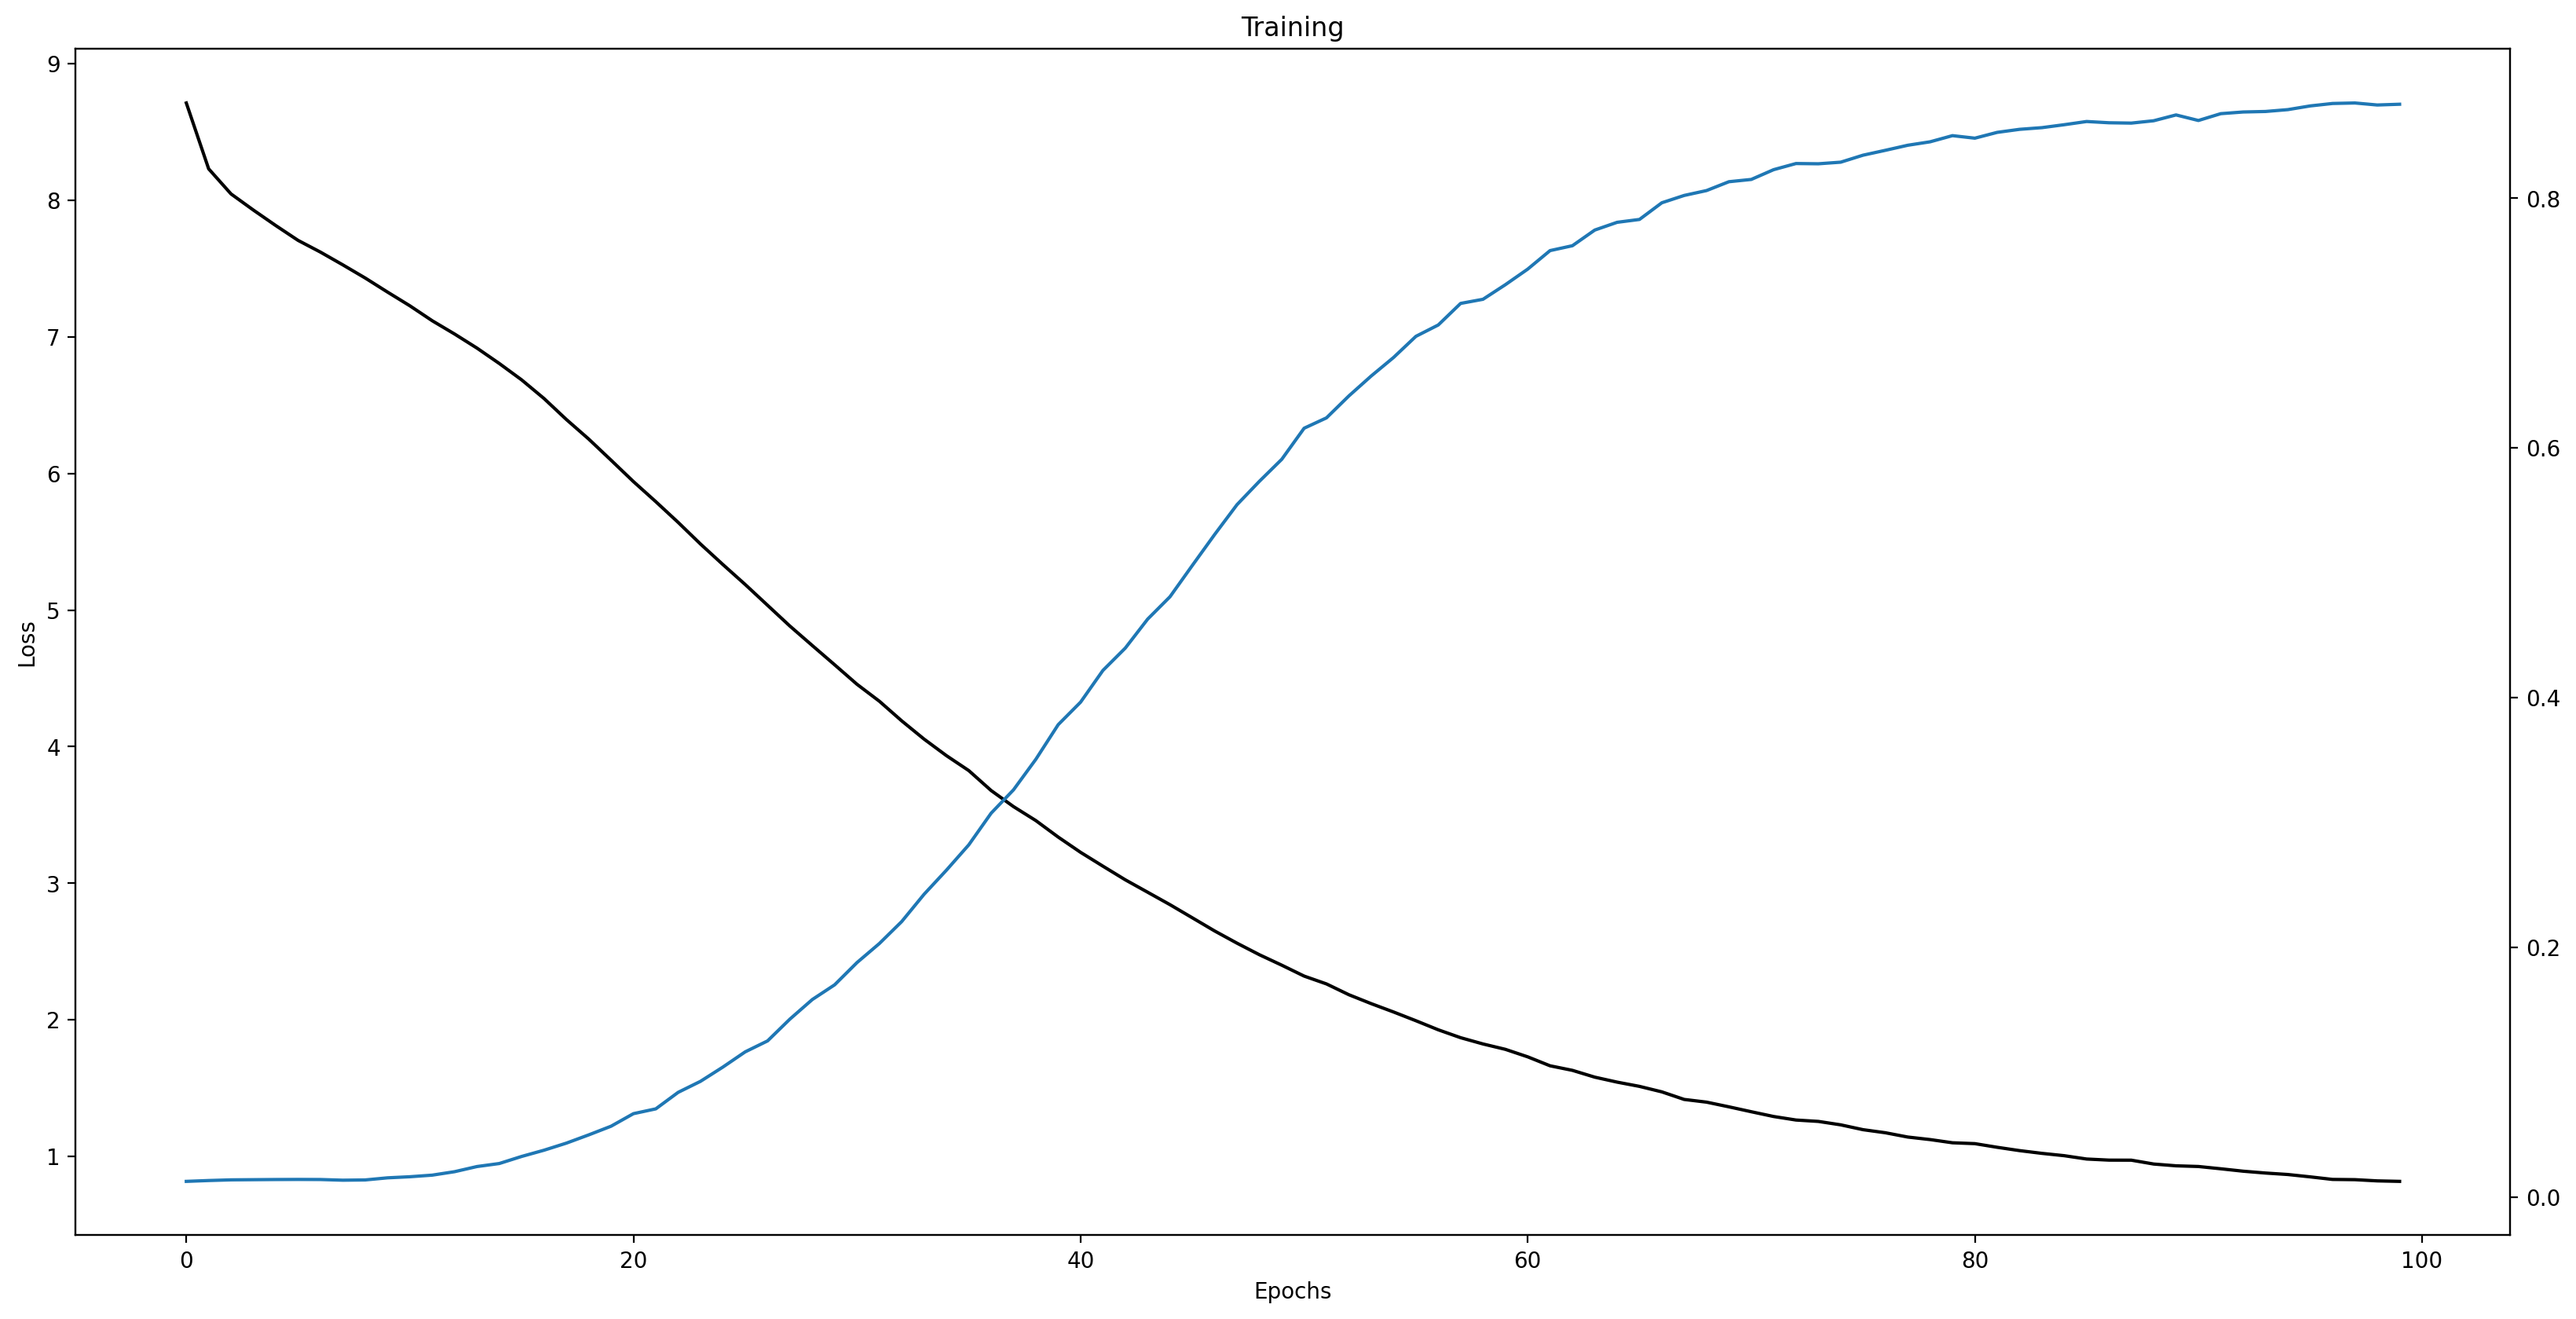

In [21]:
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True , figsize=(20,10) , dpi = 200)
ax.set(title="Training")
ax11 = ax.twinx()
ax.plot(history.history['loss'], color='black')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(history.history[metric], label=metric)
plt.show()

In [ ]:
######################################################## TESTING THE MODEL OUTPUT ########################################################

In [22]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [26]:
print (generate_text("मनको", 5, model, max_sequence_len))
print (generate_text("आमा", 5, model, max_sequence_len))
print (generate_text("माया", 5, model, max_sequence_len))
print (generate_text("तिमी", 5, model, max_sequence_len))
# print (generate_text("new york", 4, model, max_sequence_len))
# # print (generate_text("science and technology", 5, model, max_sequence_len))

मनको व्यथा कता हो कता औषधि
आमा भोकी बाटो रोकी कोही हिँडयो
माया देवदूतको मीठो खलबल प्राणहरुको भँवरी
तिमी छौ पर फाली छ घर
